# Assignment 2: Part 1 & 2 - CNN on CIFAR-10

### Setup: Mount Google Drive
All models and plots saved to `My Drive/hw2/saved/` so training can resume if interrupted.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

import os
SAVE_DIR = '/content/drive/MyDrive/hw2/saved'
CHECKPOINT_DIR = f'{SAVE_DIR}/checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Models saved to: {SAVE_DIR}")
print(f"Checkpoints saved to: {CHECKPOINT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models saved to: /content/drive/MyDrive/hw2/saved
Checkpoints saved to: /content/drive/MyDrive/hw2/saved/checkpoints


### Import Libraries
PyTorch for neural networks, torchvision for CIFAR-10, matplotlib for plotting.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Show GPU info
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
    print(f'CUDA version: {torch.version.cuda}')

Device: cuda
GPU: Tesla T4
VRAM: 15.8 GB
CUDA version: 12.6


### Load CIFAR-10 Dataset

| Setting | Value | Why |
|---------|-------|-----|
| Batch size | **256** | Larger batches = better GPU utilization |
| num_workers | **4** | Parallel data loading (CPU → GPU faster) |
| pin_memory | **True** | Faster CPU → GPU transfer |
| Images | 50,000 train, 10,000 test |
| Classes | 10 (plane, car, bird, etc.) |
| Normalization | [-1, 1] |

In [ ]:
BATCH_SIZE = 256

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True
)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f'Train: {len(trainset)}, Test: {len(testset)}')
print(f'Batch size: {BATCH_SIZE}, Batches per epoch: {len(trainloader)}')

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train: 50000, Test: 10000
Batch size: 256, Batches per epoch: 196


---
## Part 1: LeNet Architecture

### Network Structure (5×5 kernels)
| Layer | Operation | Output Shape |
|-------|-----------|-------------|
| Input | - | 32×32×3 |
| Conv1 | 6 filters, 5×5, stride=1 | 28×28×6 |
| Pool1 | 2×2 avg pool, stride=2 | 14×14×6 |
| Conv2 | 16 filters, 5×5, stride=1 | 10×10×16 |
| Pool2 | 2×2 avg pool, stride=2 | 5×5×16 |
| FC1 | 400 → 120 | 120 |
| FC2 | 120 → 84 | 84 |
| FC3 | 84 → 10 | 10 |

In [5]:
class LeNet(nn.Module):
    def __init__(self, activation='sigmoid'):
        super(LeNet, self).__init__()

        if activation == 'sigmoid':
            self.act = nn.Sigmoid()
        elif activation == 'tanh':
            self.act = nn.Tanh()
        else:
            self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_conv2_features(self, x):
        """For Part 1b: returns 16 feature maps of size 10×10."""
        x = self.pool(self.act(self.conv1(x)))
        x = self.act(self.conv2(x))
        return x

### Training & Evaluation Functions
- `train_one_epoch`: Forward pass → compute loss → backprop → update weights
- `evaluate`: Forward pass only, no gradient updates
- MSE loss requires one-hot encoded targets; CrossEntropy takes class indices directly

In [6]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        if isinstance(criterion, nn.MSELoss):
            targets = torch.zeros(labels.size(0), 10, device=device)
            targets.scatter_(1, labels.view(-1, 1), 1)
            loss = criterion(outputs, targets)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

    return total_loss / len(loader), 1 - correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if isinstance(criterion, nn.MSELoss):
                targets = torch.zeros(labels.size(0), 10, device=device)
                targets.scatter_(1, labels.view(-1, 1), 1)
                loss = criterion(outputs, targets)
            else:
                loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

    return total_loss / len(loader), 1 - correct / total

---
## Part 1a: Train 12 Combinations

### Hyperparameters
| Parameter | Values |
|-----------|--------|
| Learning Rate | **0.1**, **0.01**, **0.001** |
| Activation | **Sigmoid**, **Tanh** |
| Loss Function | **MSE**, **CrossEntropy** |
| Epochs | **30** |
| Optimizer | **SGD** |

**Total: 3 × 2 × 2 = 12 experiments**

### Checkpoint System
- **Saves every epoch** to `saved/checkpoints/` folder
- If Colab disconnects mid-training, it **resumes from last epoch**
- Once training completes, checkpoint is deleted and final model saved to `saved/`
- Already-trained models are loaded directly (no retraining)

In [7]:
NUM_EPOCHS = 30
learning_rates = [0.1, 0.01, 0.001]
activations = ['sigmoid', 'tanh']
loss_types = ['mse', 'cross_entropy']

all_results = {}

### Run All 12 Experiments
For each combination:
1. Check if fully trained → load and skip
2. Check if checkpoint exists → resume from that epoch
3. Otherwise → train from epoch 0
4. Save checkpoint after every epoch (model weights + optimizer state + history)
5. When done → save final model, delete checkpoint

In [8]:
for lr in learning_rates:
    for activation in activations:
        for loss_type in loss_types:
            name = f"{activation}_lr{lr}_{loss_type}"
            model_path = f"{SAVE_DIR}/{name}_model.pt"
            hist_path = f"{SAVE_DIR}/{name}_history.pkl"
            checkpoint_path = f"{CHECKPOINT_DIR}/{name}_checkpoint.pt"

            # If fully trained, skip
            if os.path.exists(model_path) and os.path.exists(hist_path):
                print(f"[{name}] Already trained, loading...")
                with open(hist_path, 'rb') as f:
                    history = pickle.load(f)
                all_results[name] = history
                continue

            # Setup model
            model = LeNet(activation=activation).to(device)
            criterion = nn.MSELoss() if loss_type == 'mse' else nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr)
            history = {'train_loss': [], 'test_loss': [], 'train_err': [], 'test_err': []}
            start_epoch = 0

            # Resume from checkpoint if exists
            if os.path.exists(checkpoint_path):
                print(f"[{name}] Resuming from checkpoint...")
                ckpt = torch.load(checkpoint_path)
                model.load_state_dict(ckpt['model_state'])
                optimizer.load_state_dict(ckpt['optimizer_state'])
                history = ckpt['history']
                start_epoch = ckpt['epoch'] + 1
                print(f"  Resumed at epoch {start_epoch}")
            else:
                print(f"\n[{name}] Training from scratch...")

            for epoch in range(start_epoch, NUM_EPOCHS):
                train_loss, train_err = train_one_epoch(model, trainloader, criterion, optimizer)
                test_loss, test_err = evaluate(model, testloader, criterion)

                history['train_loss'].append(train_loss)
                history['test_loss'].append(test_loss)
                history['train_err'].append(train_err)
                history['test_err'].append(test_err)

                print(f"  Epoch {epoch+1:2d}/{NUM_EPOCHS}: train_err={train_err:.4f}, test_err={test_err:.4f}")

                # Save checkpoint every epoch
                torch.save({
                    'epoch': epoch,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'history': history
                }, checkpoint_path)

            # Training complete - save final model and remove checkpoint
            torch.save(model.state_dict(), model_path)
            with open(hist_path, 'wb') as f:
                pickle.dump(history, f)
            if os.path.exists(checkpoint_path):
                os.remove(checkpoint_path)

            all_results[name] = history
            print(f"  Saved final model.")

print("\nAll 12 experiments done.")

[sigmoid_lr0.1_mse] Already trained, loading...
[sigmoid_lr0.1_cross_entropy] Already trained, loading...
[tanh_lr0.1_mse] Already trained, loading...
[tanh_lr0.1_cross_entropy] Already trained, loading...
[sigmoid_lr0.01_mse] Already trained, loading...
[sigmoid_lr0.01_cross_entropy] Already trained, loading...
[tanh_lr0.01_mse] Already trained, loading...
[tanh_lr0.01_cross_entropy] Already trained, loading...
[sigmoid_lr0.001_mse] Already trained, loading...
[sigmoid_lr0.001_cross_entropy] Already trained, loading...
[tanh_lr0.001_mse] Already trained, loading...
[tanh_lr0.001_cross_entropy] Already trained, loading...

All 12 experiments done.


### Summary Table
Final train and test error for all 12 configurations.

In [9]:
print(f"{'Config':<35} {'Train Err':>12} {'Test Err':>12}")
print("-" * 60)
for name, hist in all_results.items():
    print(f"{name:<35} {hist['train_err'][-1]:>12.4f} {hist['test_err'][-1]:>12.4f}")

Config                                 Train Err     Test Err
------------------------------------------------------------
sigmoid_lr0.1_mse                         0.8985       0.9000
sigmoid_lr0.1_cross_entropy               0.8983       0.9000
tanh_lr0.1_mse                            0.5902       0.5902
tanh_lr0.1_cross_entropy                  0.3444       0.4543
sigmoid_lr0.01_mse                        0.8999       0.9000
sigmoid_lr0.01_cross_entropy              0.9018       0.9000
tanh_lr0.01_mse                           0.6941       0.6876
tanh_lr0.01_cross_entropy                 0.5811       0.5811
sigmoid_lr0.001_mse                       0.9013       0.9005
sigmoid_lr0.001_cross_entropy             0.9029       0.9000
tanh_lr0.001_mse                          0.8443       0.8393
tanh_lr0.001_cross_entropy                0.7648       0.7557


### Plot: Train/Test Error vs Epoch (All 12 Configurations)
3×4 grid showing how each configuration converges over 30 epochs.

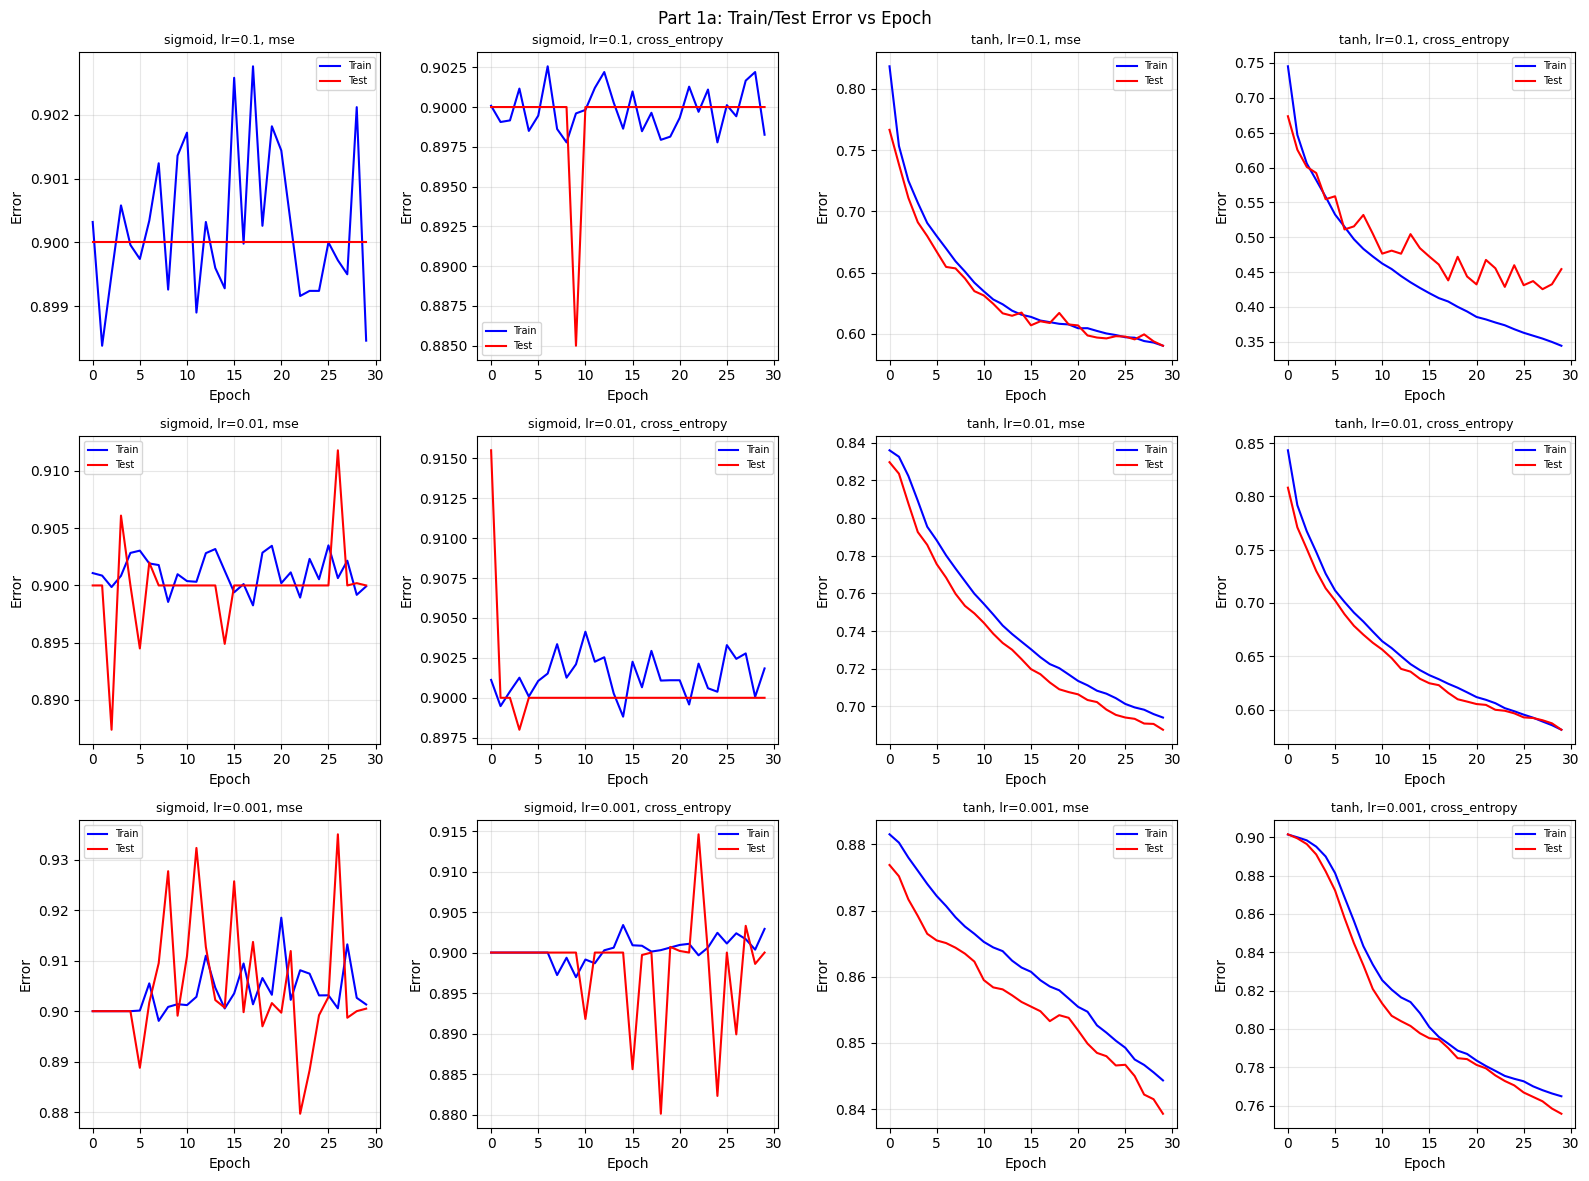

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Part 1a: Train/Test Error vs Epoch')

idx = 0
for lr in learning_rates:
    for activation in activations:
        for loss_type in loss_types:
            name = f"{activation}_lr{lr}_{loss_type}"
            hist = all_results[name]

            ax = axes[idx // 4, idx % 4]
            ax.plot(hist['train_err'], 'b-', label='Train')
            ax.plot(hist['test_err'], 'r-', label='Test')
            ax.set_title(f"{activation}, lr={lr}, {loss_type}", fontsize=9)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Error')
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
            idx += 1

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/part1a_plots.png', dpi=150)
plt.show()

### Part 1a: Analysis

**Key Observations:**

1. **Sigmoid failed completely** (~90% error = random guessing). This is due to vanishing gradients - sigmoid's max gradient is 0.25, and with 4 activation layers the gradient becomes ~0.25^4 = 0.004, too small for learning.

2. **Tanh worked** because it has larger gradients (max 1.0) and is zero-centered [-1, +1], allowing better gradient flow.

3. **Higher learning rate (0.1) worked best with tanh** - achieved 45.4% test error. Lower rates (0.01, 0.001) learned too slowly in 30 epochs.

4. **Cross-entropy outperformed MSE** for classification because its gradient is simply (predicted - actual), providing consistent learning signal.

**Best configuration:** tanh + lr=0.1 + CrossEntropy (34.4% train error, 45.4% test error)

### Confusion Matrix (Best Model)
Shows which classes are confused with each other. Diagonal = correct predictions, off-diagonal = mistakes.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


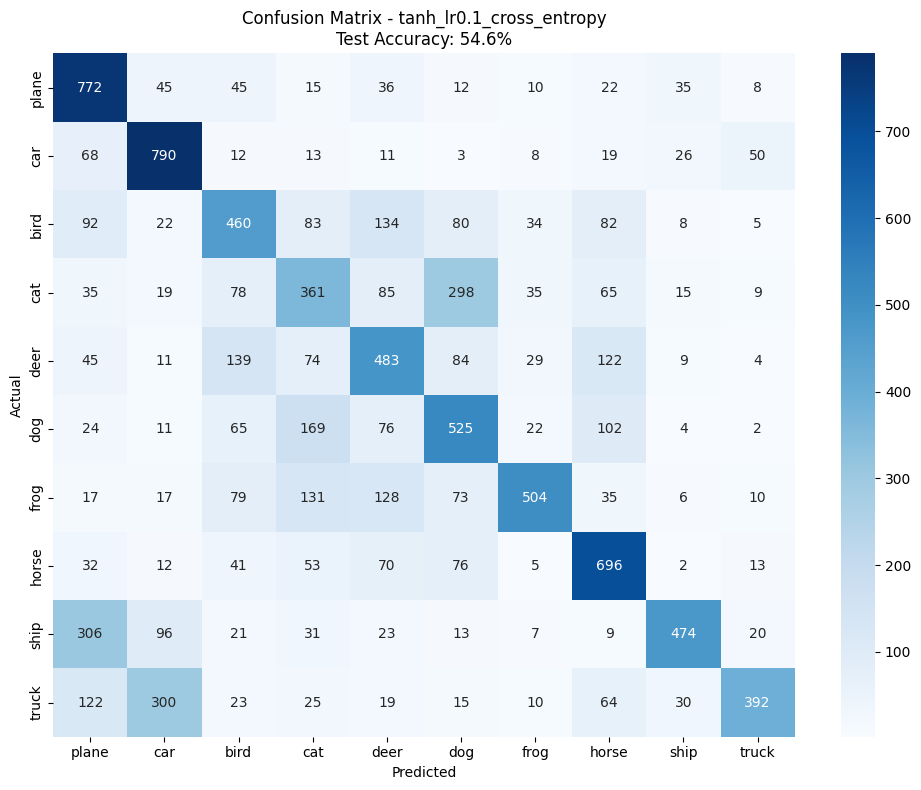


Per-class accuracy:
   plane: 77.2% (772/1000)
     car: 79.0% (790/1000)
    bird: 46.0% (460/1000)
     cat: 36.1% (361/1000)
    deer: 48.3% (483/1000)
     dog: 52.5% (525/1000)
    frog: 50.4% (504/1000)
   horse: 69.6% (696/1000)
    ship: 47.4% (474/1000)
   truck: 39.2% (392/1000)


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load best model
best_name = min(all_results.keys(), key=lambda x: all_results[x]['test_err'][-1])
act_type = best_name.split('_')[0]
best_model = LeNet(activation=act_type).to(device)
best_model.load_state_dict(torch.load(f"{SAVE_DIR}/{best_name}_model.pt"))
best_model.eval()

# Get predictions on test set
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}\nTest Accuracy: {100*(1-all_results[best_name]["test_err"][-1]):.1f}%')
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/part1a_confusion_matrix.png', dpi=150)
plt.show()

# Print per-class accuracy
print("\nPer-class accuracy:")
for i, cls in enumerate(classes):
    correct = cm[i, i]
    total = cm[i].sum()
    print(f"  {cls:>6}: {100*correct/total:.1f}% ({correct}/{total})")

### Confusion Matrix Analysis

**Per-class Performance:**
| Class | Accuracy | Observation |
|-------|----------|-------------|
| car | 79.0% | Best - distinct shape |
| plane | 77.2% | Good - unique features |
| horse | 69.6% | Good - distinctive body shape |
| dog | 52.5% | Moderate |
| frog | 50.4% | Moderate |
| deer | 48.3% | Moderate |
| ship | 47.4% | Moderate |
| bird | 46.0% | Poor |
| truck | 39.2% | Poor - confused with car |
| cat | 36.1% | Worst - confused with dog |

**Key Observations:**

1. **Vehicles vs Animals:** The model performs better on vehicles (car: 79%, plane: 77%) than most animals. Vehicles have more rigid, geometric shapes that are easier for convolution filters to detect.

2. **Cat-Dog Confusion:** Cat has the lowest accuracy (36.1%), likely because cats and dogs share similar features (fur texture, four legs, similar body proportions). The model struggles to distinguish between these visually similar classes.

3. **Truck-Car Confusion:** Truck accuracy is low (39.2%) because trucks and cars share similar features (wheels, windows, road backgrounds). The main difference is size, which is hard to capture in 32×32 images.

4. **Bird Struggles:** Bird accuracy is poor (46.0%) likely due to varied poses and backgrounds, and possible confusion with plane (both appear in sky).

5. **Best Performers:** Car and plane have distinctive, consistent shapes across samples, making them easier to classify correctly.

---
## Part 1b: Feature Map Visualization

Display feature maps at **Conv2 layer** (last convolution) for **10 images** (one per class).  
Conv2 outputs **16 feature maps** of size **10×10** each.

### Load Best Model
Uses the configuration with lowest test error from Part 1a.

In [12]:
best_name = min(all_results.keys(), key=lambda x: all_results[x]['test_err'][-1])
print(f"Using: {best_name}")

act_type = best_name.split('_')[0]
model = LeNet(activation=act_type).to(device)
model.load_state_dict(torch.load(f"{SAVE_DIR}/{best_name}_model.pt"))
model.eval()

Using: tanh_lr0.1_cross_entropy


LeNet(
  (act): Tanh()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Get Feature Maps
Select one image per class (10 total), pass through network, extract Conv2 activations.

In [13]:
images, labels = [], []
for class_idx in range(10):
    for img, lbl in testset:
        if lbl == class_idx:
            images.append(img)
            labels.append(lbl)
            break

images = torch.stack(images).to(device)

with torch.no_grad():
    features = model.get_conv2_features(images)

print(f"Feature maps shape: {features.shape}  (10 images × 16 filters × 10×10)")

Feature maps shape: torch.Size([10, 16, 10, 10])  (10 images × 16 filters × 10×10)


### Plot: Feature Maps for All 10 Images
Each row: original image + 16 feature maps. Bright areas = high activation (filter detected its pattern).

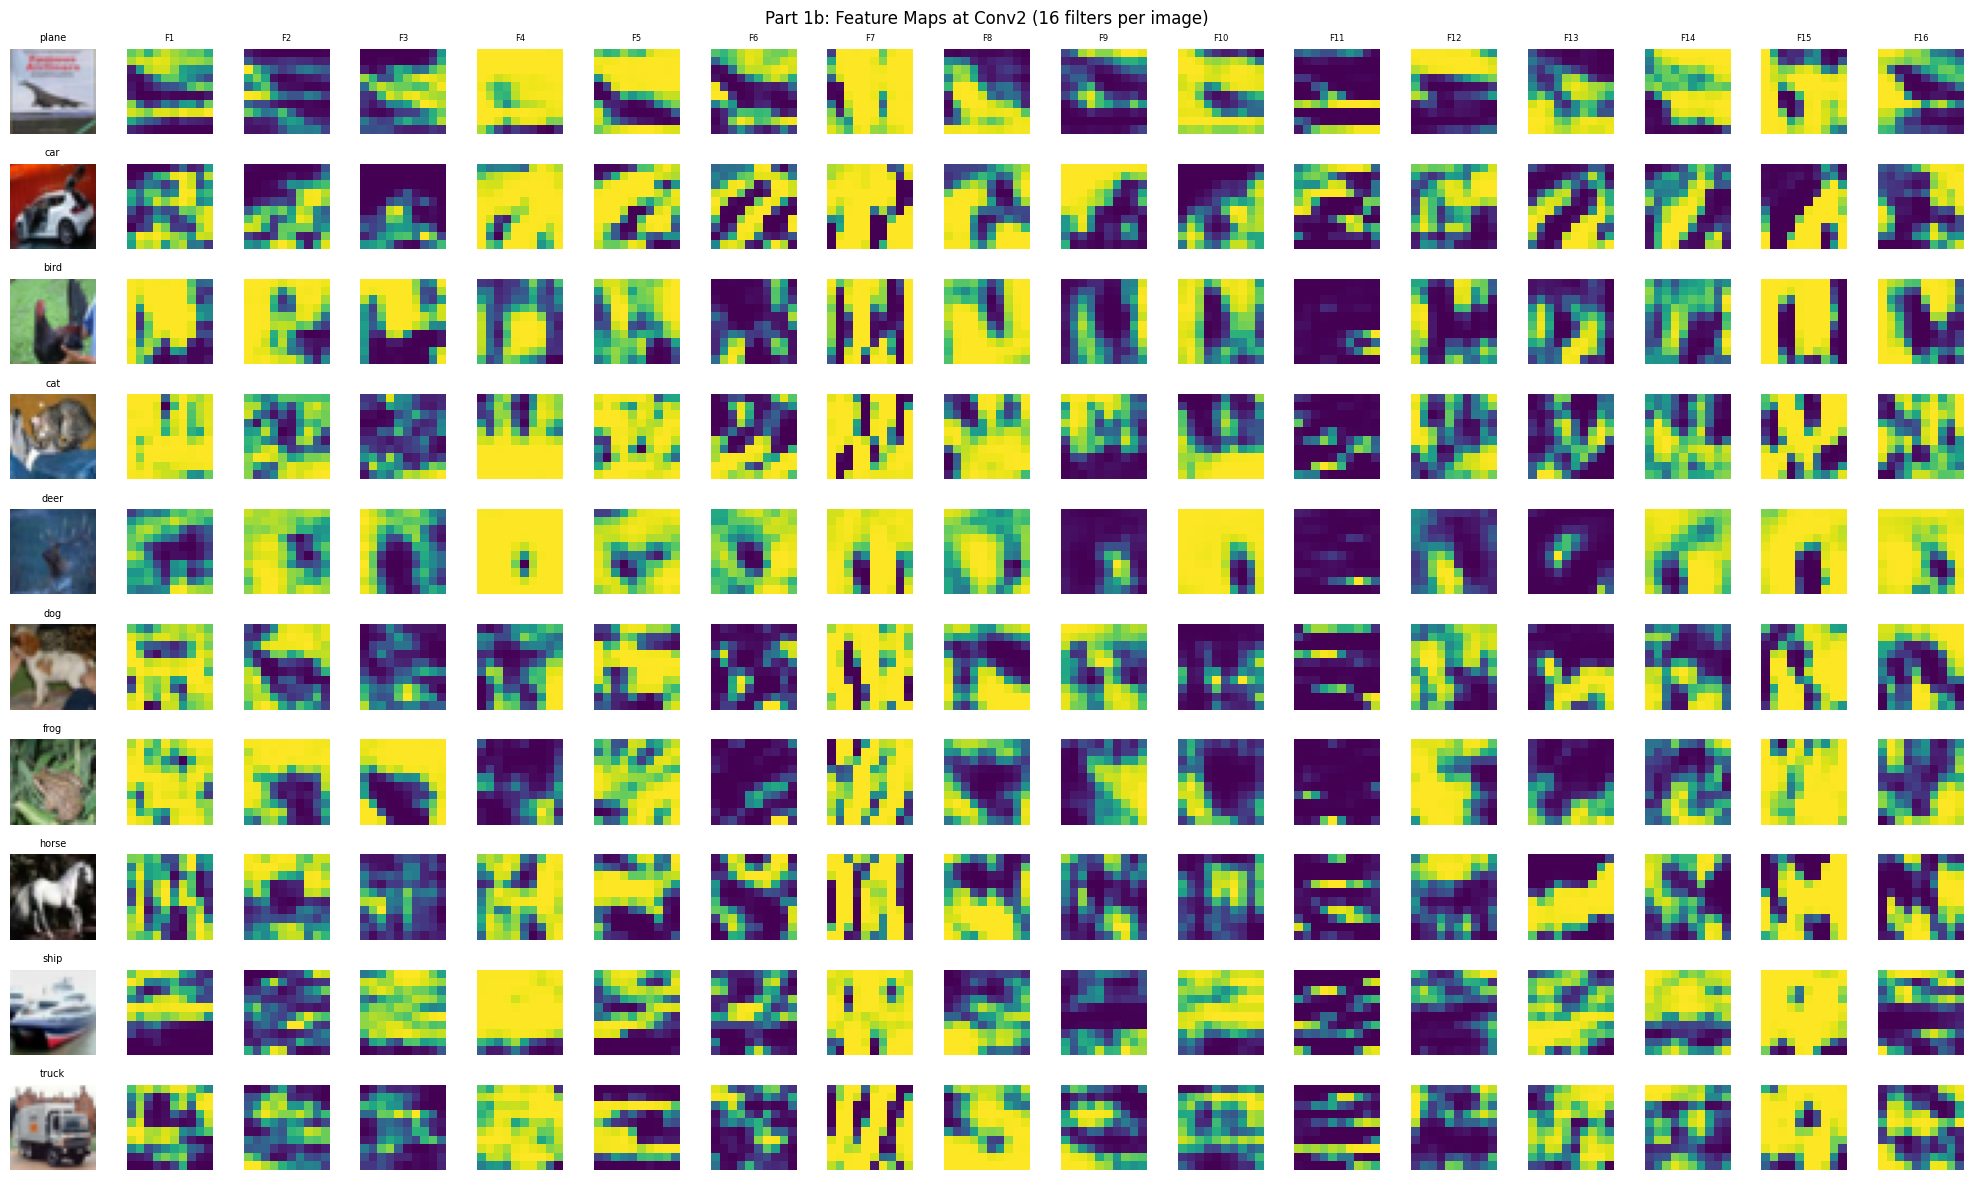

In [14]:
fig, axes = plt.subplots(10, 17, figsize=(20, 12))
fig.suptitle('Part 1b: Feature Maps at Conv2 (16 filters per image)')

for i in range(10):
    ax = axes[i, 0]
    img = images[i].cpu() / 2 + 0.5
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=7)
    ax.axis('off')

    for j in range(16):
        ax = axes[i, j + 1]
        ax.imshow(features[i, j].cpu().numpy(), cmap='viridis')
        ax.axis('off')
        if i == 0:
            ax.set_title(f'F{j+1}', fontsize=6)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/part1b_feature_maps.png', dpi=150)
plt.show()

### Part 1b: Analysis

**What has the network learned?**

The 16 feature maps at Conv2 show different patterns the network detects:

1. **Edge detectors** - filters that activate on boundaries and contours
2. **Texture patterns** - filters responding to specific textures (fur, smooth surfaces)
3. **Shape components** - different filters activate for different object parts

Vehicle classes (plane, car, ship, truck) share similar activations in filters detecting geometric shapes, while animal classes share activations in filters detecting organic/curved shapes.

The network has learned a hierarchical representation: Conv1 detects simple features (edges), Conv2 combines these into more complex patterns useful for distinguishing the 10 classes.

---
## Part 2: LeNet with 3×3 Kernels

### Hyperparameters (Fixed)
| Parameter | Value |
|-----------|-------|
| Activation | **ReLU** |
| Learning Rate | **0.001** |
| Loss | **CrossEntropy** |
| Kernel Size | **3×3** (both conv layers) |
| Epochs | **30** |

### Network Structure (3×3 kernels)
| Layer | Operation | Output Shape |
|-------|-----------|-------------|
| Input | - | 32×32×3 |
| Conv1 | 6 filters, 3×3 | 30×30×6 |
| Pool1 | 2×2 avg pool | 15×15×6 |
| Conv2 | 16 filters, 3×3 | 13×13×16 |
| Pool2 | 2×2 avg pool | 6×6×16 |
| FC1 | 576 → 120 | 120 |
| FC2 | 120 → 84 | 84 |
| FC3 | 84 → 10 | 10 |

In [15]:
class LeNet3x3(nn.Module):
    def __init__(self):
        super(LeNet3x3, self).__init__()
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(-1, 16*6*6)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

### Train 3×3 Model
ReLU + lr=0.001 + CrossEntropy + 30 epochs. Saves checkpoint every epoch; resumes if interrupted.

Loading saved 3x3 model...

3x3 Final: train_err=0.8707, test_err=0.8670


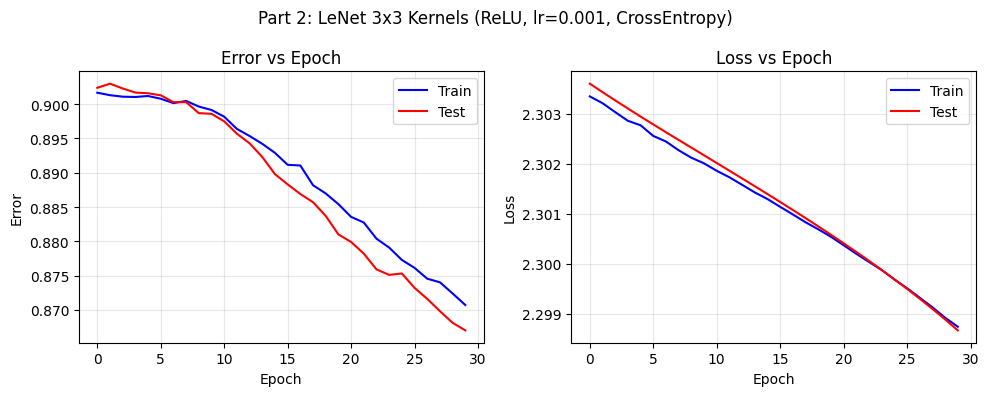

In [16]:
model_3x3_path = f"{SAVE_DIR}/lenet_3x3_model.pt"
hist_3x3_path = f"{SAVE_DIR}/lenet_3x3_history.pkl"
ckpt_3x3_path = f"{CHECKPOINT_DIR}/lenet_3x3_checkpoint.pt"

if os.path.exists(model_3x3_path) and os.path.exists(hist_3x3_path):
    print("Loading saved 3x3 model...")
    with open(hist_3x3_path, 'rb') as f:
        history_3x3 = pickle.load(f)
else:
    model_3x3 = LeNet3x3().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_3x3.parameters(), lr=0.001)
    history_3x3 = {'train_loss': [], 'test_loss': [], 'train_err': [], 'test_err': []}
    start_epoch = 0

    if os.path.exists(ckpt_3x3_path):
        print("Resuming 3x3 model from checkpoint...")
        ckpt = torch.load(ckpt_3x3_path)
        model_3x3.load_state_dict(ckpt['model_state'])
        optimizer.load_state_dict(ckpt['optimizer_state'])
        history_3x3 = ckpt['history']
        start_epoch = ckpt['epoch'] + 1
        print(f"Resumed at epoch {start_epoch}")
    else:
        print("Training 3x3 model (ReLU, lr=0.001, CrossEntropy)...")

    for epoch in range(start_epoch, NUM_EPOCHS):
        train_loss, train_err = train_one_epoch(model_3x3, trainloader, criterion, optimizer)
        test_loss, test_err = evaluate(model_3x3, testloader, criterion)

        history_3x3['train_loss'].append(train_loss)
        history_3x3['test_loss'].append(test_loss)
        history_3x3['train_err'].append(train_err)
        history_3x3['test_err'].append(test_err)

        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS}: train_err={train_err:.4f}, test_err={test_err:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state': model_3x3.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'history': history_3x3
        }, ckpt_3x3_path)

    torch.save(model_3x3.state_dict(), model_3x3_path)
    with open(hist_3x3_path, 'wb') as f:
        pickle.dump(history_3x3, f)
    if os.path.exists(ckpt_3x3_path):
        os.remove(ckpt_3x3_path)
    print("Saved final model.")

print(f"\n3x3 Final: train_err={history_3x3['train_err'][-1]:.4f}, test_err={history_3x3['test_err'][-1]:.4f}")

# Save individual plot for 3x3 model
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Part 2: LeNet 3x3 Kernels (ReLU, lr=0.001, CrossEntropy)')

axes[0].plot(history_3x3['train_err'], 'b-', label='Train')
axes[0].plot(history_3x3['test_err'], 'r-', label='Test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Error')
axes[0].set_title('Error vs Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_3x3['train_loss'], 'b-', label='Train')
axes[1].plot(history_3x3['test_loss'], 'r-', label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss vs Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/part2_3x3_individual.png', dpi=150)
plt.show()

### Train 5×5 Model with ReLU (for fair comparison)
Same hyperparameters as 3×3 (ReLU, lr=0.001, CrossEntropy) but with 5×5 kernels. Saves checkpoint every epoch; resumes if interrupted.

Loading saved 5x5 ReLU model...

5x5 Final: train_err=0.8876, test_err=0.8886


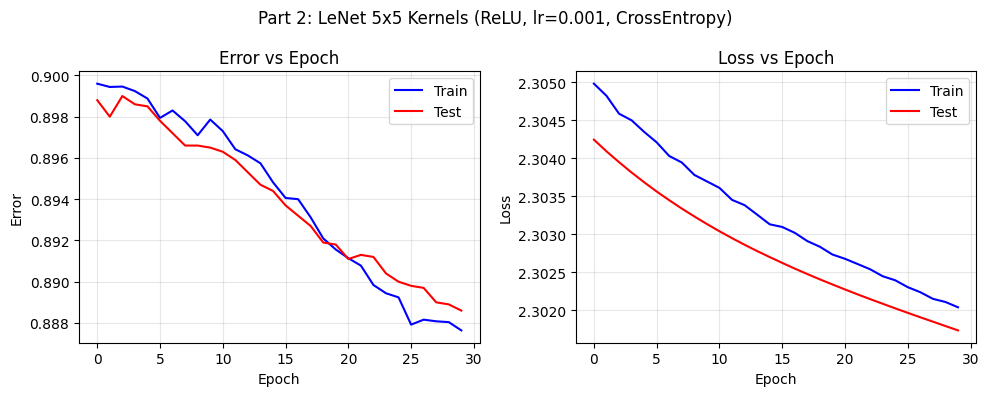

In [17]:
model_5x5_path = f"{SAVE_DIR}/lenet_5x5_relu_model.pt"
hist_5x5_path = f"{SAVE_DIR}/lenet_5x5_relu_history.pkl"
ckpt_5x5_path = f"{CHECKPOINT_DIR}/lenet_5x5_relu_checkpoint.pt"

if os.path.exists(model_5x5_path) and os.path.exists(hist_5x5_path):
    print("Loading saved 5x5 ReLU model...")
    with open(hist_5x5_path, 'rb') as f:
        history_5x5 = pickle.load(f)
else:
    model_5x5 = LeNet(activation='relu').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_5x5.parameters(), lr=0.001)
    history_5x5 = {'train_loss': [], 'test_loss': [], 'train_err': [], 'test_err': []}
    start_epoch = 0

    if os.path.exists(ckpt_5x5_path):
        print("Resuming 5x5 ReLU model from checkpoint...")
        ckpt = torch.load(ckpt_5x5_path)
        model_5x5.load_state_dict(ckpt['model_state'])
        optimizer.load_state_dict(ckpt['optimizer_state'])
        history_5x5 = ckpt['history']
        start_epoch = ckpt['epoch'] + 1
        print(f"Resumed at epoch {start_epoch}")
    else:
        print("Training 5x5 model (ReLU, lr=0.001, CrossEntropy)...")

    for epoch in range(start_epoch, NUM_EPOCHS):
        train_loss, train_err = train_one_epoch(model_5x5, trainloader, criterion, optimizer)
        test_loss, test_err = evaluate(model_5x5, testloader, criterion)

        history_5x5['train_loss'].append(train_loss)
        history_5x5['test_loss'].append(test_loss)
        history_5x5['train_err'].append(train_err)
        history_5x5['test_err'].append(test_err)

        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS}: train_err={train_err:.4f}, test_err={test_err:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state': model_5x5.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'history': history_5x5
        }, ckpt_5x5_path)

    torch.save(model_5x5.state_dict(), model_5x5_path)
    with open(hist_5x5_path, 'wb') as f:
        pickle.dump(history_5x5, f)
    if os.path.exists(ckpt_5x5_path):
        os.remove(ckpt_5x5_path)
    print("Saved final model.")

print(f"\n5x5 Final: train_err={history_5x5['train_err'][-1]:.4f}, test_err={history_5x5['test_err'][-1]:.4f}")

# Save individual plot for 5x5 model
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Part 2: LeNet 5x5 Kernels (ReLU, lr=0.001, CrossEntropy)')

axes[0].plot(history_5x5['train_err'], 'b-', label='Train')
axes[0].plot(history_5x5['test_err'], 'r-', label='Test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Error')
axes[0].set_title('Error vs Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_5x5['train_loss'], 'b-', label='Train')
axes[1].plot(history_5x5['test_loss'], 'r-', label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss vs Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/part2_5x5_individual.png', dpi=150)
plt.show()

### Plot: 5×5 vs 3×3 Comparison
Both use ReLU, lr=0.001, CrossEntropy. Only difference is kernel size.

### Part 2: Analysis

**Comparison with 5x5 ReLU (same hyperparameters):**
- Both kernel sizes learn effectively with ReLU (no vanishing gradient)
- 5x5 captures more spatial context per convolution (25 vs 9 pixels)
- 3x3 has fewer conv parameters but larger FC layers due to bigger feature maps

**Comparison with Part 1 (5x5 tanh/sigmoid):**
- ReLU avoids vanishing gradients entirely (gradient is 0 or 1), unlike sigmoid which failed
- With lr=0.001, both 3x3 and 5x5 ReLU learn slower than tanh with lr=0.1, but more stably

### Part 2: Analysis

**How do 3x3 results differ from 5x5?**

1. **Receptive field**: 5x5 kernel sees 25 pixels per operation, 3x3 sees only 9 pixels. The 5x5 captures more spatial context in a single convolution.

2. **Parameters**: 3x3 conv layers have fewer parameters (1,048 vs 2,872), but the larger feature maps (6x6 vs 5x5) lead to more FC1 parameters.

3. **Both work with ReLU**: Unlike sigmoid which failed in Part 1, ReLU avoids vanishing gradients entirely (gradient is 0 or 1), so both kernel sizes learn effectively.

4. **Modern preference**: Deeper networks prefer 3x3 kernels because two 3x3 layers equal one 5x5 receptive field with fewer parameters and more non-linearities.